In [59]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import re
import tqdm
import os
from collections import defaultdict

In [92]:
plt.rcParams.update({
    # 'figure.figsize': (6, 4),            # Figure size
    # 'figure.dpi': 100,                   # High DPI for publication-quality images
    # 'axes.titlesize': 14,                # Title font size
    # 'axes.labelsize': 12,                # Axis label font size
    # 'axes.labelpad': 10,                 # Padding for labels
    # 'axes.linewidth': 1,                 # Axis line width
    # 'axes.grid': False,                  # Disable grid unless necessary
    # 'xtick.labelsize': 10,               # X-axis tick label size
    # 'ytick.labelsize': 10,               # Y-axis tick label size
    # 'xtick.major.size': 4,               # Length of major ticks
    # 'ytick.major.size': 4,               # Length of major ticks
    # 'xtick.major.width': 1,              # Width of major ticks
    # 'ytick.major.width': 1,              # Width of major ticks
    # 'xtick.direction': 'in',             # Ticks facing inwards
    # 'ytick.direction': 'in',             # Ticks facing inwards
    # 'legend.fontsize': 10,               # Legend font size
    # 'legend.frameon': False,             # Disable legend frame for a cleaner look
    'font.family': 'serif',              # Use a serif font for text
    'font.serif': ['DejaVu Serif'],      # Use 'DejaVu Serif' as the fallback serif font
    # 'lines.linewidth': 1.5,              # Line width for plots
    # 'lines.markersize': 6,               # Marker size
    # 'savefig.dpi': 300,                  # Save figure resolution
    # 'savefig.bbox': 'tight',             # Adjust layout to avoid clipping
})

In [99]:
# Load the stats data from the folder
model_keys = [
    # '/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/allenai_OLMoE-1B-7B-0924',
    #'/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/allenai_OLMoE-1B-7B-0924-Instruct'
    #'/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/google_gemma-2-2b',
    # '/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/google_gemma-2-2b-it',
    # '/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/google_gemma-2b',
    # '/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/keeeeenw_MicroLlama',
    # '/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/meta-llama_Llama-3.1-8B',
    # '/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/meta-llama_Llama-3.1-8B-Instruct',
    # '/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/meta-llama_Llama-3.1-70B',
    # '/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/microsoft_phi-2',
    # '/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/microsoft_Phi-3.5-mini-instruct',
    # '/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/mistralai_Mistral-7B-Instruct-v0.3',
    # '/home/davidchan/Repos/random_needles/exps/contextual/coin_flip/mistralai_Mistral-7B-v0.3',
    '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/google_gemma-2-2b',
    '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/meta-llama_Llama-3.1-8B',
    '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/microsoft_phi-2',
    '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/mistralai_Mistral-7B-v0.3',
    '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/allenai_OLMoE-1B-7B-0924',
    '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/allenai_OLMoE-1B-7B-0924-Instruct',
    '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/google_gemma-2-2b-it',
    '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/meta-llama_Llama-3.1-8B-Instruct',
    '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/microsoft_Phi-3.5-mini-instruct',
    '/home/rcorona/2024/random_needle/exps/contextual/coin_flip/mistralai_Mistral-7B-Instruct-v0.3'
]

model_stats_data = {}
for key in tqdm.tqdm(model_keys):
    if os.path.exists(f'{key}/stats.pkl'):
        with open(f'{key}/stats.pkl', 'rb') as f:
            model_stats_data[key.split('/')[-1]] = pickle.load(f)

100%|██████████| 10/10 [00:00<00:00, 60.62it/s]


In [100]:
def tvd(p, q):
    return 0.5 * np.sum(np.abs(p - q))

In [101]:
# Extract unbiased point data.
unbiased_point_data = {}
for key, stats in model_stats_data.items():
    unbiased_point_data[key] = stats['unconditional_point']

# Extract biased point data.
biased_point_data = {}
for key, stats in model_stats_data.items():
    biased_point_data[key] = []
    if 'biased_point' not in stats:
        continue
    for k, v in stats['biased_point'].items():
        percent = int(re.search(r"(\d+(\.\d+)?)%", k).group(1))
        biased_point_data[key].append((percent, tvd(v['choice_probs'], np.exp(v["expected_dist"]))))
    biased_point_data[key] = sorted(biased_point_data[key], key=lambda x: x[0])

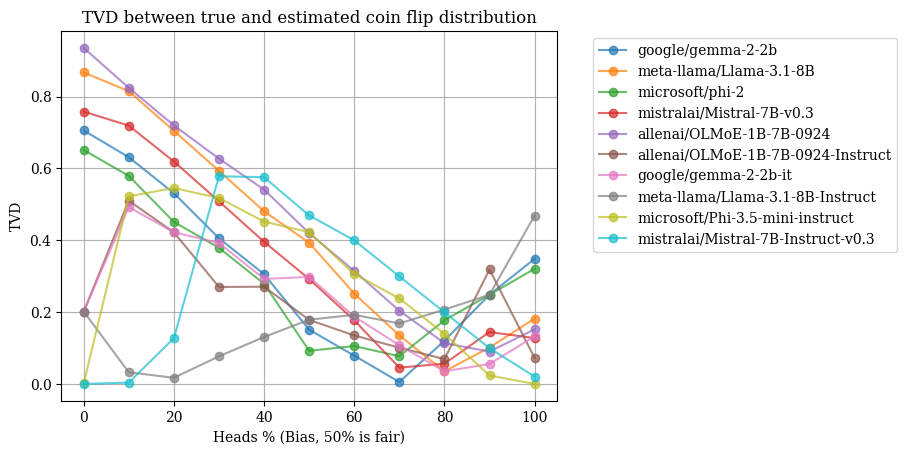

<Figure size 640x480 with 0 Axes>

In [102]:
plt.clf()
for key, data in biased_point_data.items():
    plt.plot([x[0] for x in data], [x[1] for x in data], '-o', label=key.replace('_', '/'), alpha=0.7)

# Add a baseline key: (predicting 50/50 for all biases)
# baseline = [(x, tvd(np.array([0.5, 0.5]), np.array([x / 100, (100 - x) / 100]))) for x in range(0, 101)]
# plt.plot([x[0] for x in baseline], [x[1] for x in baseline], label='Baseline (50/50)', linestyle='--', color='black')

plt.xlabel('Heads % (Bias, 50% is fair)')
plt.ylabel('TVD')
plt.legend(bbox_to_anchor=(1.7, 1))
plt.grid()
plt.title('TVD between true and estimated coin flip distribution')
plt.show()

# Save as pdf.
plt.savefig('coin_flip_tvd_std.pdf', bbox_inches='tight')

# Pivot Tables

In [147]:
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

def gen_data_frame(stats, key):
    # Format data as pandas dataframe.
    data = []

    for (context_len, doc_depth, needle), point_stats in stats[key].items():

        data.append({
            'Context Length': context_len,
            'Depth': doc_depth,
            'TVD': tvd(point_stats['choice_probs'], np.exp(point_stats["expected_dist"])),
            'Needle': needle
        })

    # If unbiased experiment, add a row for 0 context length.
    if key == 'pivot_table':

        # Extract unbiased point data and add it to the dataframe, this is TVD at 0 context length.
        zero_context_tvd = tvd(unbiased_point_data[model_name]['choice_probs'], np.exp(unbiased_point_data[model_name]['expected_dist']))

        # Add new row.
        data.append({
            'Context Length': 0,
            'Depth': 0,
            'TVD': zero_context_tvd,
            'Needle': 'Unbiased'
        })

    df = pd.DataFrame(data)

    return df

def bias_needle_pivot_table(df, model_name, index_axes=['Context Length', 'Depth']):
    """
    Generate experiment output for multiple data points (i.e. context and document depth used.)

    Pivot table code based on: https://github.com/gkamradt/LLMTest_NeedleInAHaystack/blob/main/viz/CreateVizFromLLMTesting.ipynb
    """
    # Extract axes.
    axis1, axis2 = index_axes[0], index_axes[1]

    # Create pivot table to visualize data.
    pivot_table = pd.pivot_table(df, values='TVD', index=index_axes, aggfunc=np.mean).reset_index()
    pivot_table = pivot_table.pivot(index=axis2, columns=axis1, values="TVD")

    # Color map.
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#0CD79F", "#EBB839", "#F0496E"])

    # Create the heatmap with better aesthetics
    plt.clf()
    ax = sns.heatmap(
        pivot_table,
        # annot=True,
        fmt="g",
        cmap=cmap,
        # cbar_kws={'label': 'TVD'},
        # vmin=0.0,
        # vmax=1.0
    )
    ax.collections[0].colorbar.ax.tick_params(labelsize=18)  # Increase the font size of the colorbar labels

    # More aesthetics
    # plt.title(f'Pivot table for {model_name} indexed over {index_axes}')  # Adds a title
    # plt.xlabel(axis1)  # X-axis label
    # plt.ylabel(axis2)  # Y-axis label
    # plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
    # plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
    # plt.tight_layout()  # Fits everything neatly into the figure area
    plt.title(f'{model_name.replace("_", "/")}', fontsize=25)  # Adds a title
    plt.xlabel(axis1, fontsize=24)  # X-axis label
    plt.ylabel(axis2, fontsize=24)  # Y-axis label
    plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
    plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
    plt.tight_layout()  # Fits everything neatly into the figure area
    plt.savefig(f'{model_name}_context_pivot_table.pdf', bbox_inches='tight')


def bias_needle_pivot_table_sort(df, model_name, index_axes=['Context Length', 'Depth']):
    """
    Generate experiment output for multiple data points (i.e. context and document depth used.)

    Pivot table code based on: https://github.com/gkamradt/LLMTest_NeedleInAHaystack/blob/main/viz/CreateVizFromLLMTesting.ipynb
    """
    # Extract axes.
    axis1, axis2 = index_axes[0], index_axes[1]

    # Function to extract percentage from strings in axis2
    def extract_percentage(text):
        match = re.search(r'(\d+)%', text)  # Look for digits followed by a '%'
        if match:
            return int(match.group(1))  # Convert the matched percentage to an integer
        return None  # Return None if no percentage is found

    # Apply the function to the axis2 column
    df['percentage'] = df[axis2].apply(extract_percentage)

    # Drop rows with missing percentage if needed
    df = df.dropna(subset=['percentage'])

    index_axes[1] = 'percentage'  # Update axis2 to use the extracted percentage
    axis2 = 'percentage'  # Update axis2 to use the extracted percentage

    # Create pivot table to visualize data.
    pivot_table = pd.pivot_table(df, values='TVD', index=index_axes, aggfunc=np.mean).reset_index()
    pivot_table = pivot_table.pivot(index=axis2, columns=axis1, values="TVD")

    # Color map.
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#0CD79F", "#EBB839", "#F0496E"])

    # Create the heatmap with better aesthetics
    plt.clf()
    ax = sns.heatmap(
        pivot_table,
        # annot=True,
        fmt="g",
        cmap=cmap,
        vmin=0.0,
        vmax=1.0,
    )
    ax.collections[0].colorbar.ax.tick_params(labelsize=18)  # Increase the font size of the colorbar labels


    # More aesthetics
    plt.title(f'{model_name.replace("_", "/")}', fontsize=25)  # Adds a title
    plt.xlabel('Context Length', fontsize=24)  # X-axis label
    plt.ylabel('Bias %', fontsize=24)  # Y-axis label
    plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
    plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
    plt.tight_layout()  # Fits everything neatly into the figure area
    plt.savefig(f'{model_name}_needle_pivot_table.pdf', bbox_inches='tight')

def unbiased_exp_plot(df_data, unbiased_point_data):
    """
    Generate unbiased experiments plot.
    """
    # Create the plot
    plt.figure(figsize=(17.5, 8))  # Can adjust these dimensions as needed

    # Iterate over each model.
    for model_name, data in df_data.items():

        # Extract TVD and STD.
        model_tvd = data['unbiased_df'].groupby(['Context Length', 'Depth', 'Needle']).mean().reset_index()
        model_std = data['unbiased_df'].groupby(['Context Length', 'Depth', 'Needle']).std().reset_index()

        # Plot the data.
        plt.plot(model_tvd['Context Length'], model_tvd['TVD'], label=f'{model_name} - TVD', alpha=0.7)

        # Fill between the standard deviation.
        plt.fill_between(
            model_tvd['Context Length'],
            model_tvd['TVD'] - model_std['TVD'],
            model_tvd['TVD'] + model_std['TVD'],
            alpha=0.2
        )

    # # More aesthetics
    plt.title('Unbiased Experiments')  # Adds a title
    plt.xlabel('Token Limit')  # X-axis label
    plt.ylabel('TVD')  # Y-axis label
    plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
    plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
    plt.legend()  # Adds a legend
    plt.tight_layout()  # Fits everything neatly into the figure area
    plt.show()


In [143]:
# Generate data frames for all models.
df_data = {}

for model_name, stats in model_stats_data.items():

    # Generate data frame for both biased and unbiased context experiments.
    unbiased_df = gen_data_frame(stats, 'pivot_table')
    biased_df = gen_data_frame(stats, 'needle_pivot_table')

    df_data[model_name] = {
        'unbiased_df': unbiased_df,
        'biased_df': biased_df
    }

/tmp/ipykernel_1821505/398578979.py:46: FutureWarning: The provided callable <function mean at 0x7a82bc0c3600> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = pd.pivot_table(df, values='TVD', index=index_axes, aggfunc=np.mean).reset_index()
/tmp/ipykernel_1821505/398578979.py:107: FutureWarning: The provided callable <function mean at 0x7a82bc0c3600> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = pd.pivot_table(df, values='TVD', index=index_axes, aggfunc=np.mean).reset_index()
/tmp/ipykernel_1821505/398578979.py:46: FutureWarning: The provided callable <function mean at 0x7a82bc0c3600> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To

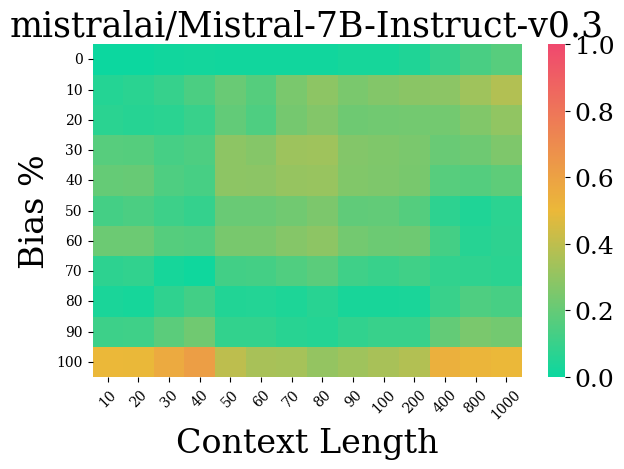

In [148]:

# Generate biase needle pivot tables.
for model_name, data in df_data.items():
    bias_needle_pivot_table(data['biased_df'], model_name)
    bias_needle_pivot_table_sort(data['biased_df'], model_name, index_axes=['Context Length', 'Needle'])

In [154]:
# Stats PKL files
# /home/davidchan/Repos/random_needles/exps/contextual/coin_flip_icl_v2/icl_1/10/google_gemma-2-2b/stats.pkl

model_map = {
    'google/Gemma-2-2B': '../exps/contextual/coin_flip_icl_v2/icl_{icl_length}/{bias}/google_gemma-2-2b/stats.pkl',
    'google/Gemma-2-2B-IT': '../exps/contextual/coin_flip_icl_v2/icl_{icl_length}/{bias}/google_gemma-2-2b-it/stats.pkl',
    'meta-llama/Llama-3.1-8B': '../exps/contextual/coin_flip_icl_v2/icl_{icl_length}/{bias}/meta-llama_Llama-3.1-8B/stats.pkl',
    'meta-llama/Llama-3.1-8B-Instruct': '../exps/contextual/coin_flip_icl_v2/icl_{icl_length}/{bias}/meta-llama_Llama-3.1-8B-Instruct/stats.pkl',
    'microsoft/Phi-3.5-mini-instruct': '../exps/contextual/coin_flip_icl_v2/icl_{icl_length}/{bias}/microsoft_Phi-3.5-mini-instruct/stats.pkl',
}

In [155]:
# Explore a ICL file
icl_length = 1
bias = 10

icl_file = model_map['google/Gemma-2-2B'].format(icl_length=icl_length, bias=bias)
with open(icl_file, 'rb') as f:
    icl_data = pickle.load(f)

icl_data.keys()

dict_keys(['averaged_stats', 'stats_over_prompts'])

In [156]:
icl_data['averaged_stats']['biased_point']['When I flip coins they land on heads 10% of the time.']['tvd']['mean']

np.float64(0.7175031250715256)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

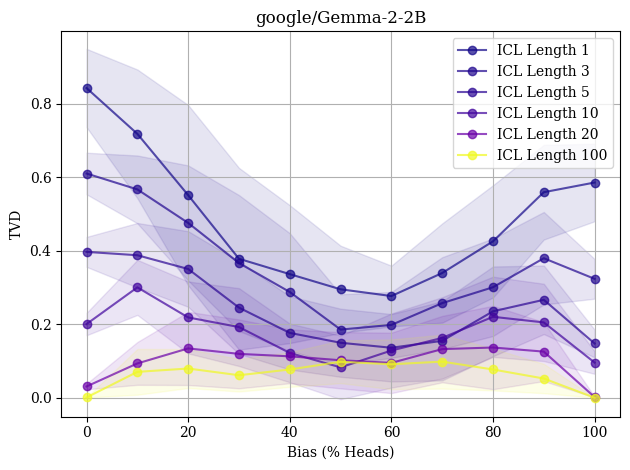

In [159]:
# model = 'google/Gemma-2-2B'
# model = 'meta-llama/Llama-3.1-8B'
for model in ['meta-llama/Llama-3.1-8B', 'google/Gemma-2-2B']:
    data = defaultdict(list)
    for icl_length in (1,3,5,10,20,100):
        for bias in (0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100):
            icl_file = model_map[model].format(icl_length=icl_length, bias=bias)
            if not os.path.exists(icl_file):
                continue
            with open(icl_file, 'rb') as f:
                icl_data = pickle.load(f)
            data[icl_length].append((
                bias,
                icl_data['averaged_stats']['biased_point'][f'When I flip coins they land on heads {bias}% of the time.']['tvd']['mean'],
                icl_data['averaged_stats']['biased_point'][f'When I flip coins they land on heads {bias}% of the time.']['tvd']['std']
            ))

    plt.clf()
    plt.figure()
    for icl_length, values in data.items():
        plt.plot([x[0] for x in values], [x[1] for x in values], '-o', label=f'ICL Length {icl_length}',  alpha=0.7, color=plt.cm.plasma(icl_length / 100))
        plt.fill_between([x[0] for x in values], [x[1] - x[2] for x in values], [x[1] + x[2] for x in values], alpha=0.1, color=plt.cm.plasma(icl_length / 100))

    plt.grid()
    plt.title(model)
    plt.xlabel('Bias (% Heads)')
    plt.ylabel('TVD')
    plt.tight_layout()
    plt.legend(loc='upper right')
    plt.savefig(f'{model.replace("/", "_")}_icl_tvd.pdf', bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

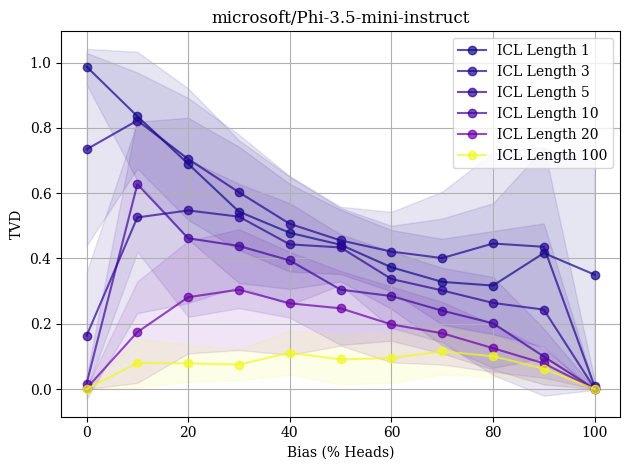

In [161]:
model = 'meta-llama/Llama-3.1-8B-Instruct'
for model in ['meta-llama/Llama-3.1-8B-Instruct', 'google/Gemma-2-2B-IT', 'microsoft/Phi-3.5-mini-instruct']:
    data = defaultdict(list)
    for icl_length in (1,3,5,10,20,100):
        for bias in (0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100):
            icl_file = model_map[model].format(icl_length=icl_length, bias=bias)
            if not os.path.exists(icl_file):
                continue
            with open(icl_file, 'rb') as f:
                icl_data = pickle.load(f)
            try:
                data[icl_length].append((
                    bias,
                    icl_data['averaged_stats']['biased_point'][f'When you flip coins, they land on heads {bias}% of the time.']['tvd']['mean'],
                    icl_data['averaged_stats']['biased_point'][f'When you flip coins, they land on heads {bias}% of the time.']['tvd']['std']
                ))
            except:
                print(icl_file)
                print( icl_data['averaged_stats']['biased_point'].keys())
                continue

    plt.clf()
    plt.figure()
    for icl_length, values in data.items():
        plt.plot([x[0] for x in values], [x[1] for x in values], '-o', label=f'ICL Length {icl_length}',  alpha=0.7, color=plt.cm.plasma(icl_length / 100))
        plt.fill_between([x[0] for x in values], [x[1] - x[2] for x in values], [x[1] + x[2] for x in values], alpha=0.1, color=plt.cm.plasma(icl_length / 100))

    plt.grid()
    plt.title(model)
    plt.xlabel('Bias (% Heads)')
    plt.ylabel('TVD')
    plt.tight_layout()
    plt.legend(loc='upper right')
    plt.savefig(f'{model.replace("/", "_")}_icl_tvd.pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

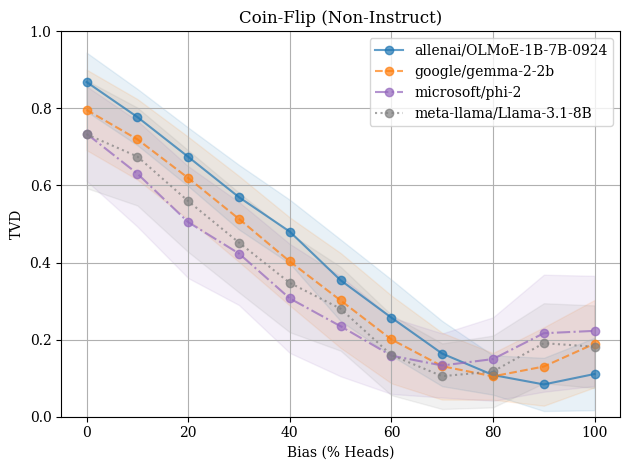

In [93]:
# Plot all models
import glob
import itertools
root_dir = '../exps/contextual/coin_flip_multiset'

# Discover all folders in the root directory
folders = glob.glob(f'{root_dir}/*')

# Extract model names
model_names = [folder.split('/')[-1] for folder in folders]

# Load all stats
data = defaultdict(list)
for model_name in model_names:
    stats_file = f'{root_dir}/{model_name}/stats.pkl'
    if not os.path.exists(stats_file):
        continue
    with open(stats_file, 'rb') as f:
        model_stats_data[model_name] = pickle.load(f)
    model_is_instruct = 'it' in model_name.lower() or 'instruct' in model_name.lower()
    for bias in (0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100):
        if model_is_instruct:
            key = f'When you flip coins, they land on heads {bias}% of the time.'
        else:
            key = f'When I flip coins they land on heads {bias}% of the time.'
        try:
            data[model_name].append((
                bias,
                model_is_instruct,
                model_stats_data[model_name]['averaged_stats']['biased_point'][key]['tvd']['mean'],
                model_stats_data[model_name]['averaged_stats']['biased_point'][key]['tvd']['std']
            ))
        except:
            print(model_name)
            print(model_stats_data[model_name]['averaged_stats']['biased_point'].keys())
            continue

# Plot non-instruct models
plt.clf()
plt.figure()
linestyles = itertools.cycle(['-o', '--o', '-.o', ':o', '-s', '--s', '-.s', ':s', '-^', '--^', '-.^', ':^'])
for i, (model_name, values) in enumerate(data.items()):
    if not values[0][1]:
        color = plt.cm.tab10(i)
        if 'MicroLlama' in model_name:
            continue

        plt.plot([x[0] for x in values], [x[2] for x in values], next(linestyles), label=model_name.replace('_', '/'),  alpha=0.7, color=color)
        plt.fill_between([x[0] for x in values], [x[2] - x[3] for x in values], [x[2] + x[3] for x in values], alpha=0.1, color=color)

plt.grid()
plt.title('Coin-Flip (Non-Instruct)')
plt.xlabel('Bias (% Heads)')
plt.ylabel('TVD')
plt.ylim(0,1)
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('coin_flip_non_instruct.pdf', bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

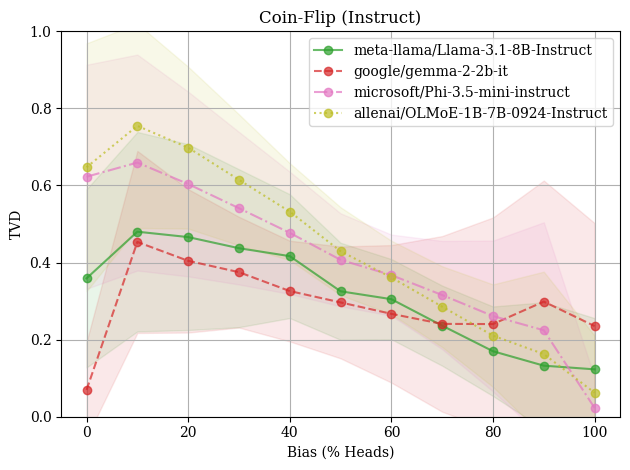

In [94]:
# Plot all models
import glob
import itertools
root_dir = '../exps/contextual/coin_flip_multiset'

# Discover all folders in the root directory
folders = glob.glob(f'{root_dir}/*')

# Extract model names
model_names = [folder.split('/')[-1] for folder in folders]

# Load all stats
data = defaultdict(list)
for model_name in model_names:
    stats_file = f'{root_dir}/{model_name}/stats.pkl'
    if not os.path.exists(stats_file):
        continue
    with open(stats_file, 'rb') as f:
        model_stats_data[model_name] = pickle.load(f)
    model_is_instruct = 'it' in model_name.lower() or 'instruct' in model_name.lower()
    for bias in (0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100):
        if model_is_instruct:
            key = f'When you flip coins, they land on heads {bias}% of the time.'
        else:
            key = f'When I flip coins they land on heads {bias}% of the time.'
        try:
            data[model_name].append((
                bias,
                model_is_instruct,
                model_stats_data[model_name]['averaged_stats']['biased_point'][key]['tvd']['mean'],
                model_stats_data[model_name]['averaged_stats']['biased_point'][key]['tvd']['std']
            ))
        except:
            print(model_name)
            print(model_stats_data[model_name]['averaged_stats']['biased_point'].keys())
            continue

# Plot non-instruct models
plt.clf()
plt.figure()
linestyles = itertools.cycle(['-o', '--o', '-.o', ':o', '-s', '--s', '-.s', ':s', '-^', '--^', '-.^', ':^'])
for i, (model_name, values) in enumerate(data.items()):
    if values[0][1]:
        color = plt.cm.tab10(i)

        plt.plot([x[0] for x in values], [x[2] for x in values], next(linestyles), label=model_name.replace('_', '/'),  alpha=0.7, color=color)
        plt.fill_between([x[0] for x in values], [x[2] - x[3] for x in values], [x[2] + x[3] for x in values], alpha=0.1, color=color)

plt.grid()
plt.ylim(0, 1)
plt.title('Coin-Flip (Instruct)')
plt.xlabel('Bias (% Heads)')
plt.ylabel('TVD')
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('coin_flip_instruct.pdf', bbox_inches='tight')
